# Quickstart

This notebook will:

1. Load the datasets: `data/train.pkl`, `data/x_test.pkl` and `data/y_test_local.pkl`.
2. Fit per-window ARIMA models on 60-minute input sequences to forecast the following 10 minutes.
3. Perform evaluation:
   - **Local validation** on `y_test_local.pkl` (window_id 1–2)  
   - **Official metrics:** MSE, MAE, IC, IR, Sharpe Ratio, MDD, VaR, ES  
   - **Trading snapshots:** CSM and LOTQ
4. Run inference on `x_test` and generate a PICKLE submission file at `sample_submission/submission.pkl`.
5. Save dummy `model_weights.pkl` into `sample_submission/` for submission compatibility. *(note: this is only a minimal example; in real deep learning models the weights file would be generated automatically during training.)*

In [1]:
import os, sys, json, time, warnings
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

/tmp2/b10902109/conda_envs/crypto_forecast/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Paths (adjust if your layout differs)
ROOT = Path.cwd().parent if (Path.cwd().name == 'src') else Path.cwd()
DATA = ROOT / "data"
SRC  = ROOT / "src"
SUBM = ROOT / "sample_submission"

# Ensure src is importable
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

# Create sample_submission dir if missing
SUBM.mkdir(parents=True, exist_ok=True)

SEED = 1337
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [3]:
# Load dataset files
info_path = DATA / "dataset_info.json"
if info_path.exists():
    info = json.loads(info_path.read_text(encoding="utf-8"))
    print("dataset_info.json loaded. Keys:", list(info.keys()))
    print(json.dumps({k: info[k] for k in ['features','input_len','horizon_len','outputs']}, indent=2))
else:
    print("dataset_info.json not found at", info_path)

# Peek train / x_test
train_path = DATA / "train.pkl"
x_test_path  = DATA / "x_test.pkl"
y_local_path = DATA / "y_test_local_time.pkl"

train = pd.read_pickle(train_path)
x_test  = pd.read_pickle(x_test_path)
y_test_local = pd.read_pickle(y_local_path)

print("train shape:", train.shape, "| columns:", train.columns.tolist())
print("x_test  shape:", x_test.shape,  "| columns:", x_test.columns.tolist())
print("y_test_local_time shape:", y_test_local.shape, "| columns:", y_test_local.columns.tolist())

display(train.head(3))
display(x_test.head(3))
display(y_test_local.head(3))

dataset_info.json loaded. Keys: ['freq', 'features', 'input_len', 'horizon_len', 'dtypes', 'outputs', 'sha256']
{
  "features": [
    "close",
    "volume"
  ],
  "input_len": 60,
  "horizon_len": 10,
  "outputs": {
    "train": {
      "columns": [
        "series_id",
        "time_step",
        "close",
        "volume"
      ]
    },
    "x_test": {
      "columns": [
        "window_id",
        "time_step",
        "close",
        "volume"
      ]
    },
    "y_test_local": {
      "columns": [
        "window_id",
        "time_step",
        "close"
      ]
    }
  }
}
train shape: (18331224, 4) | columns: ['series_id', 'time_step', 'close', 'volume']
x_test  shape: (3000000, 4) | columns: ['window_id', 'time_step', 'close', 'volume']
y_test_local_time shape: (100, 5) | columns: ['window_id', 'time_step', 'close', 'event_datetime', 'token']


,series_id,time_step,close,volume
0,1,0,0.13700,171985.703125
1,1,1,0.13656,85451.398438
2,1,2,0.13647,121151.898438


,window_id,time_step,close,volume
0,1,0,0.1126,24976.0
1,1,1,0.1126,0.0
2,1,2,0.1125,2299.0


,window_id,time_step,close,event_datetime,token
0,1,0,0.1131,2025-01-01 00:00:00+00:00,XLMUSDT
1,1,1,0.1131,2025-01-01 00:01:00+00:00,XLMUSDT
2,1,2,0.1130,2025-01-01 00:02:00+00:00,XLMUSDT


In [4]:
# Use the sampler logic from src/dataset.py to slice windows
from dataset import TrainWindowSampler

class WindowsDataset(Dataset):
    """
    Wrap TrainWindowSampler into a PyTorch Dataset.
    Returns:
      X: (60, 2) float32 -> [close, volume]
      y: (10,)  float32 -> future close
    """
    def __init__(self, train_path: str, rolling: bool = True, step_size: int = 1, max_samples: int = None):
        self.sampler = TrainWindowSampler(
            train_path=train_path,
            window=70,
            input_len=60,
            horizon_len=10,
            rolling=rolling,
            step_size=step_size,
            seed=SEED,
        )
        # Materialize (optionally capped) for stable batching
        xs, ys = [], []
        for i, (X, y) in enumerate(self.sampler.iter_windows()):
            xs.append(X.astype(np.float32))
            ys.append(y.astype(np.float32))
            if max_samples is not None and (i + 1) >= max_samples:
                break
        self.X = np.stack(xs, axis=0) if xs else np.zeros((0,60,2), dtype=np.float32)
        self.y = np.stack(ys, axis=0) if ys else np.zeros((0,10), dtype=np.float32)

    def __len__(self):  return len(self.X)
    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), torch.from_numpy(self.y[i])

# For a quick demo, cap samples. Increase for better quality.
MAX_SAMPLES = 50000  # set to None to use all windows
train_ds = WindowsDataset(str(train_path), rolling=True, step_size=1, max_samples=MAX_SAMPLES)
len(train_ds), train_ds.X.shape, train_ds.y.shape

(50000, (50000, 60, 2), (50000, 10))

In [5]:
# ARIMA baseline
from baselines.arima import ARIMABaseline

ari = ARIMABaseline(order=(1,1,0), maxiter=50)
ari.fit(train)

# Save dummy weights after fitting
import pickle
from pathlib import Path

weights_out = SUBM / "model_weights.pkl"
with open(weights_out, "wb") as f:
    pickle.dump({"config": ari.cfg.__dict__}, f)

print("Saved dummy weights to", weights_out)

Saved dummy weights to /tmp2/b10902109/ICAIF Competition/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit/sample_submission/model_weights.pkl


In [6]:
# Fast preview inference on a subset of x_test (NOT for official submission).
# For official submission, run full inference over all windows.

FIRST_N_WINDOWS = 500       # set to an integer (e.g., 500). Set to None to disable.

all_wids = x_test['window_id'].drop_duplicates().astype('int32').to_numpy()
base_sel = all_wids[:int(FIRST_N_WINDOWS)] if FIRST_N_WINDOWS is not None else all_wids # you need to run on all windows for official submission

must_wids = np.array([1, 2], dtype=np.int32)
exist_mask = np.isin(must_wids, all_wids)
if not exist_mask.all():
    missing = must_wids[~exist_mask].tolist()
    warnings.warn(f"[Preview] Required window_id(s) not in x_test: {missing}")
sel_wids = np.unique(np.concatenate([base_sel, must_wids[exist_mask]]))
print(f"Infer on {len(sel_wids)} / {len(all_wids)} windows "
      f"(forced include: {must_wids[exist_mask].tolist()})")

# Build a subset view (optional when running preview)
x_test_view = x_test[x_test['window_id'].isin(sel_wids)] if FIRST_N_WINDOWS is not None else x_test

# predict -> submission-like DataFrame
submission_df = ari.predict_x_test(x_test_view)   # columns: window_id, time_step, pred_close

# validate shape for selected windows
if not submission_df.empty:
    counts = submission_df.groupby('window_id')['time_step'].nunique()
    assert (counts == 10).all(), "Each selected window_id must have exactly 10 rows (0..9)."

# Save preview (NOT for official submission)
# For official submission, run inference on ALL windows and save to sample_submission/submission.pkl
# out_path = SUBM / "submission.pkl"
out_path = SUBM / "submission_example.pkl"
submission_df.to_pickle(out_path)
print(f"Saved preview to {out_path}  rows={len(submission_df)}  "
      f"windows={submission_df['window_id'].nunique()}")
display(submission_df.head(12))

print("NOTE: This is a PREVIEW subset. For official submission, you must run full inference on ALL windows.")

Infer on 500 / 50000 windows (forced include: [1, 2])


ARIMA infer: 100%|██████████| 500/500 [00:10<00:00, 47.90it/s]

Saved preview to /tmp2/b10902109/ICAIF Competition/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit/sample_submission/submission_example.pkl  rows=5000  windows=500


,window_id,time_step,pred_close
0,1,0,0.113100
1,1,1,0.113100
2,1,2,0.113100
3,1,3,0.113100
4,1,4,0.113100
5,1,5,0.113100
6,1,6,0.113100
7,1,7,0.113100
8,1,8,0.113100
9,1,9,0.113100


NOTE: This is a PREVIEW subset. For official submission, you must run full inference on ALL windows.


In [ ]:
# Local test on window_id {1,2} with y_test_local.pkl
if not y_local_path.exists():
    warnings.warn(f"y_test_local_time.pkl not found at: {y_local_path}. Skip local eval.")
else:
    # NOTE: updated evaluate_all_metrics expects (y_true, y_pred, x_like, y_true_with_base, horizon_step)
    from metrics import evaluate_all_metrics

    target_wids = [1, 2]
    y_local = pd.read_pickle(y_local_path)     # ground truth: ['window_id','time_step','close','event_datetime','token']
    pred_local = submission_df[submission_df["window_id"].isin(target_wids)].copy()

    # Integrity check: each selected window must have exactly 10 prediction steps
    if not pred_local.empty:
        _c = pred_local.groupby("window_id")["time_step"].nunique()
        assert (_c == 10).all(), f"Incomplete prediction steps: {_c.to_dict()}"

    # Build x_like from x_test: use time_step == 59 as base_close reference
    x_test_local = x_test[x_test["window_id"].isin(target_wids)].copy()

    # Normalize dtypes for consistency
    for df in (y_local, pred_local, x_test_local):
        if "window_id" in df: df["window_id"] = df["window_id"].astype("int32")
        if "time_step" in df: df["time_step"] = df["time_step"].astype("int8")
        if "close" in df: df["close"] = df["close"].astype("float32")
        if "pred_close" in df: df["pred_close"] = df["pred_close"].astype("float32")

    # Keep only ground truth for {1,2}
    y_true_local = y_local[y_local["window_id"].isin(target_wids)].copy()

    # Verify that y_true_local has event_datetime column
    if "event_datetime" not in y_true_local.columns:
        raise ValueError("y_test_local_time.pkl must contain 'event_datetime' column")
    
    print(f"\ny_true_local columns: {y_true_local.columns.tolist()}")
    print(f"pred_local columns: {pred_local.columns.tolist()}")
    print(f"x_test_local columns: {x_test_local.columns.tolist()}")

    # Compute metrics: error metrics + strategy-based (CSM/LOTQ/PW) Sharpe, MDD, VaR, ES
    try:
        metrics_dict = evaluate_all_metrics(
            y_true=y_true_local,
            y_pred=pred_local,
            x_test=x_test_local,
            alpha=0.05,
        )
        
        print("\n" + "="*60)
        print("Local Evaluation on window_id 1 & 2 (using NEW metrics)")
        print("="*60)
        
        # Display metrics in a nice format
        metrics_df = pd.DataFrame([metrics_dict]).T.rename(columns={0: "value"})
        display(metrics_df)
    
        
    except Exception as e:
        print(f"\n❌ Error during metric evaluation: {e}")
        import traceback
        traceback.print_exc()

print("\n" + "="*60)
print("Script completed successfully!")
print("="*60)


y_true_local columns: ['window_id', 'time_step', 'close', 'event_datetime', 'token']
pred_local columns: ['window_id', 'time_step', 'pred_close']
x_test_local columns: ['window_id', 'time_step', 'close', 'volume']

Local Evaluation on window_id 1 & 2 (using NEW metrics)


,value
MSE,2.324934e-08
MAE,1.313759e-04
IC,5.333333e-01
IR,2.828427e+00
SharpeRatio,2.759568e+00
MDD,0.000000e+00
VaR,1.187174e-03
ES,1.186768e-03



Script completed successfully!


In [8]:
# Test different ARIMA orders to find the one with minimum MSE
from itertools import product
import time

# Define parameter ranges to test
p_range = [0, 1, 2]  # AR order
d_range = [0, 1]     # Differencing order
q_range = [0, 1, 2]  # MA order

# Generate all combinations
orders_to_test = list(product(p_range, d_range, q_range))
# Remove (0,0,0) as it's not a valid ARIMA model
orders_to_test = [order for order in orders_to_test if not all(x == 0 for x in order)]

print(f"Testing {len(orders_to_test)} different ARIMA orders...")
print("Orders to test:", orders_to_test)

results = []

for i, order in enumerate(orders_to_test):
    print(f"\n[{i+1}/{len(orders_to_test)}] Testing ARIMA{order}...")
    
    try:
        start_time = time.time()
        
        # Create and fit ARIMA model
        ari_test = ARIMABaseline(order=order, maxiter=50)
        ari_test.fit(train)
        
        # Run inference on test windows (using same subset as before)
        submission_test = ari_test.predict_x_test(x_test_view)
        
        # Calculate metrics on local validation set
        pred_test = submission_test[submission_test["window_id"].isin(target_wids)].copy()
        
        if not pred_test.empty:
            # Normalize dtypes
            for df in (pred_test,):
                if "window_id" in df: df["window_id"] = df["window_id"].astype("int32")
                if "time_step" in df: df["time_step"] = df["time_step"].astype("int8")
                if "pred_close" in df: df["pred_close"] = df["pred_close"].astype("float32")
            
            # Calculate metrics
            metrics_test = evaluate_all_metrics(
                y_true=y_true_local,
                y_pred=pred_test,
                x_test=x_test_local,
                alpha=0.05,
            )
            
            elapsed_time = time.time() - start_time
            
            result = {
                'order': order,
                'p': order[0],
                'd': order[1], 
                'q': order[2],
                'MSE': metrics_test['MSE'],
                'MAE': metrics_test['MAE'],
                'IC': metrics_test['IC'],
                'IR': metrics_test['IR'],
                'SharpeRatio': metrics_test['SharpeRatio'],
                'MDD': metrics_test['MDD'],
                'VaR': metrics_test['VaR'],
                'ES': metrics_test['ES'],
                'time_seconds': elapsed_time
            }
            
            results.append(result)
            print(f"  MSE: {metrics_test['MSE']:.2e}, MAE: {metrics_test['MAE']:.2e}, Time: {elapsed_time:.1f}s")
        else:
            print(f"  No predictions generated for order {order}")
            
    except Exception as e:
        print(f"  Error with order {order}: {str(e)}")
        continue

print(f"\n\nCompleted testing {len(results)} models successfully!")

Testing 17 different ARIMA orders...
Orders to test: [(0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2)]

[1/17] Testing ARIMA(0, 0, 1)...


ARIMA infer: 100%|██████████| 500/500 [00:20<00:00, 24.44it/s]
/tmp2/b10902109/ICAIF Competition/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit/src/metrics.py:76: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic = spearmanr(g["pred_ret"], g["true_ret"], nan_policy="omit")[0]
/tmp2/b10902109/ICAIF Competition/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit/src/metrics.py:94: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic = spearmanr(g["pred_ret"], g["true_ret"], nan_policy="omit")[0]


  MSE: 8.33e-03, MAE: 8.76e-02, Time: 20.6s

[2/17] Testing ARIMA(0, 0, 2)...


ARIMA infer: 100%|██████████| 500/500 [00:37<00:00, 13.38it/s]
/tmp2/b10902109/ICAIF Competition/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit/src/metrics.py:76: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic = spearmanr(g["pred_ret"], g["true_ret"], nan_policy="omit")[0]
/tmp2/b10902109/ICAIF Competition/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit/src/metrics.py:94: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic = spearmanr(g["pred_ret"], g["true_ret"], nan_policy="omit")[0]


  MSE: 9.01e-03, MAE: 8.94e-02, Time: 37.5s

[3/17] Testing ARIMA(0, 1, 0)...


ARIMA infer: 100%|██████████| 500/500 [00:08<00:00, 60.44it/s]


  MSE: 2.08e-08, MAE: 1.24e-04, Time: 8.4s

[4/17] Testing ARIMA(0, 1, 1)...


ARIMA infer: 100%|██████████| 500/500 [00:15<00:00, 32.67it/s]


  MSE: 2.17e-08, MAE: 1.26e-04, Time: 15.4s

[5/17] Testing ARIMA(0, 1, 2)...


ARIMA infer: 100%|██████████| 500/500 [00:18<00:00, 26.82it/s]


  MSE: 1.89e-08, MAE: 1.17e-04, Time: 18.8s

[6/17] Testing ARIMA(1, 0, 0)...


ARIMA infer: 100%|██████████| 500/500 [00:09<00:00, 50.39it/s]


  MSE: 4.90e-08, MAE: 1.91e-04, Time: 10.0s

[7/17] Testing ARIMA(1, 0, 1)...


ARIMA infer: 100%|██████████| 500/500 [00:20<00:00, 24.25it/s]


  MSE: 5.09e-08, MAE: 1.95e-04, Time: 20.7s

[8/17] Testing ARIMA(1, 0, 2)...


ARIMA infer: 100%|██████████| 500/500 [00:26<00:00, 19.20it/s]


  MSE: 4.94e-08, MAE: 1.92e-04, Time: 26.2s

[9/17] Testing ARIMA(1, 1, 0)...


ARIMA infer: 100%|██████████| 500/500 [00:10<00:00, 49.57it/s]


  MSE: 2.32e-08, MAE: 1.31e-04, Time: 10.2s

[10/17] Testing ARIMA(1, 1, 1)...


ARIMA infer: 100%|██████████| 500/500 [00:20<00:00, 23.93it/s]


  MSE: 2.12e-08, MAE: 1.25e-04, Time: 21.0s

[11/17] Testing ARIMA(1, 1, 2)...


ARIMA infer: 100%|██████████| 500/500 [00:25<00:00, 19.41it/s]


  MSE: 1.90e-08, MAE: 1.18e-04, Time: 25.9s

[12/17] Testing ARIMA(2, 0, 0)...


ARIMA infer: 100%|██████████| 500/500 [00:15<00:00, 32.52it/s]


  MSE: 5.31e-08, MAE: 2.00e-04, Time: 15.5s

[13/17] Testing ARIMA(2, 0, 1)...


ARIMA infer: 100%|██████████| 500/500 [00:29<00:00, 16.70it/s]


  MSE: 5.13e-08, MAE: 1.97e-04, Time: 30.1s

[14/17] Testing ARIMA(2, 0, 2)...


ARIMA infer: 100%|██████████| 500/500 [00:31<00:00, 16.09it/s]


  MSE: 5.39e-08, MAE: 2.03e-04, Time: 31.2s

[15/17] Testing ARIMA(2, 1, 0)...


ARIMA infer: 100%|██████████| 500/500 [00:13<00:00, 37.84it/s]


  MSE: 2.15e-08, MAE: 1.26e-04, Time: 13.3s

[16/17] Testing ARIMA(2, 1, 1)...


ARIMA infer: 100%|██████████| 500/500 [00:24<00:00, 20.03it/s]


  MSE: 1.03e+03, MAE: 8.96e+00, Time: 25.1s

[17/17] Testing ARIMA(2, 1, 2)...


ARIMA infer: 100%|██████████| 500/500 [00:33<00:00, 14.76it/s]


  MSE: 4.26e-08, MAE: 1.68e-04, Time: 34.0s


Completed testing 17 models successfully!


In [9]:
# Analyze results and find best performing orders
if results:
    results_df = pd.DataFrame(results)
    
    # Sort by MSE (ascending) to find best models
    results_df_sorted = results_df.sort_values('MSE')
    
    print("=" * 80)
    print("ARIMA ORDER COMPARISON RESULTS")
    print("=" * 80)
    
    # Display top 5 models by MSE
    print("\nTOP 5 MODELS (sorted by MSE):")
    print("-" * 50)
    top_5 = results_df_sorted.head(5)
    for idx, row in top_5.iterrows():
        print(f"ARIMA{row['order']} - MSE: {row['MSE']:.2e}, MAE: {row['MAE']:.2e}, Sharpe: {row['SharpeRatio']:.3f}")
    
    print("\nDETAILED RESULTS TABLE:")
    print("-" * 50)
    display_cols = ['p', 'd', 'q', 'MSE', 'MAE', 'IC', 'SharpeRatio', 'time_seconds']
    display(results_df_sorted[display_cols].round(6))
    
    # Find best model
    best_order = results_df_sorted.iloc[0]['order']
    best_mse = results_df_sorted.iloc[0]['MSE']
    
    print(f"\n🏆 BEST MODEL: ARIMA{best_order}")
    print(f"   MSE: {best_mse:.2e}")
    print(f"   Improvement over ARIMA(1,1,0): {((metrics_dict['MSE'] - best_mse) / metrics_dict['MSE'] * 100):.2f}%")
    
    # Compare different aspects
    print("\nCOMPARISON BY DIFFERENT METRICS:")
    print("-" * 40)
    print(f"Best MSE: ARIMA{results_df_sorted.iloc[0]['order']} ({results_df_sorted.iloc[0]['MSE']:.2e})")
    print(f"Best MAE: ARIMA{results_df_sorted.sort_values('MAE').iloc[0]['order']} ({results_df_sorted.sort_values('MAE').iloc[0]['MAE']:.2e})")
    print(f"Best Sharpe: ARIMA{results_df_sorted.sort_values('SharpeRatio', ascending=False).iloc[0]['order']} ({results_df_sorted.sort_values('SharpeRatio', ascending=False).iloc[0]['SharpeRatio']:.3f})")
    print(f"Best IC: ARIMA{results_df_sorted.sort_values('IC', ascending=False).iloc[0]['order']} ({results_df_sorted.sort_values('IC', ascending=False).iloc[0]['IC']:.3f})")
else:
    print("No successful results to analyze.")

ARIMA ORDER COMPARISON RESULTS

TOP 5 MODELS (sorted by MSE):
--------------------------------------------------
ARIMA(0, 1, 2) - MSE: 1.89e-08, MAE: 1.17e-04, Sharpe: 2.760
ARIMA(1, 1, 2) - MSE: 1.90e-08, MAE: 1.18e-04, Sharpe: 2.760
ARIMA(0, 1, 0) - MSE: 2.08e-08, MAE: 1.24e-04, Sharpe: 2.760
ARIMA(1, 1, 1) - MSE: 2.12e-08, MAE: 1.25e-04, Sharpe: 2.760
ARIMA(2, 1, 0) - MSE: 2.15e-08, MAE: 1.26e-04, Sharpe: 2.760

DETAILED RESULTS TABLE:
--------------------------------------------------


,p,d,q,MSE,MAE,IC,SharpeRatio,time_seconds
4,0,1,2,0.000000,0.000117,0.533333,2.759568,18.756139
10,1,1,2,0.000000,0.000118,0.533333,2.759568,25.872653
2,0,1,0,0.000000,0.000124,0.533333,2.759568,8.389508
9,1,1,1,0.000000,0.000125,0.533333,2.759568,21.002677
14,2,1,0,0.000000,0.000126,0.533333,2.759568,13.323913
3,0,1,1,0.000000,0.000126,0.533333,2.759568,15.412053
8,1,1,0,0.000000,0.000131,0.533333,2.759568,10.202654
16,2,1,2,0.000000,0.000168,0.533333,2.759568,33.997054
5,1,0,0,0.000000,0.000191,0.533333,2.759568,10.030574
7,1,0,2,0.000000,0.000192,0.533333,2.759568,26.157669



🏆 BEST MODEL: ARIMA(0, 1, 2)
   MSE: 1.89e-08
   Improvement over ARIMA(1,1,0): 18.63%

COMPARISON BY DIFFERENT METRICS:
----------------------------------------
Best MSE: ARIMA(0, 1, 2) (1.89e-08)
Best MAE: ARIMA(0, 1, 2) (1.17e-04)
Best Sharpe: ARIMA(2, 0, 2) (2.760)
Best IC: ARIMA(0, 1, 2) (0.533)


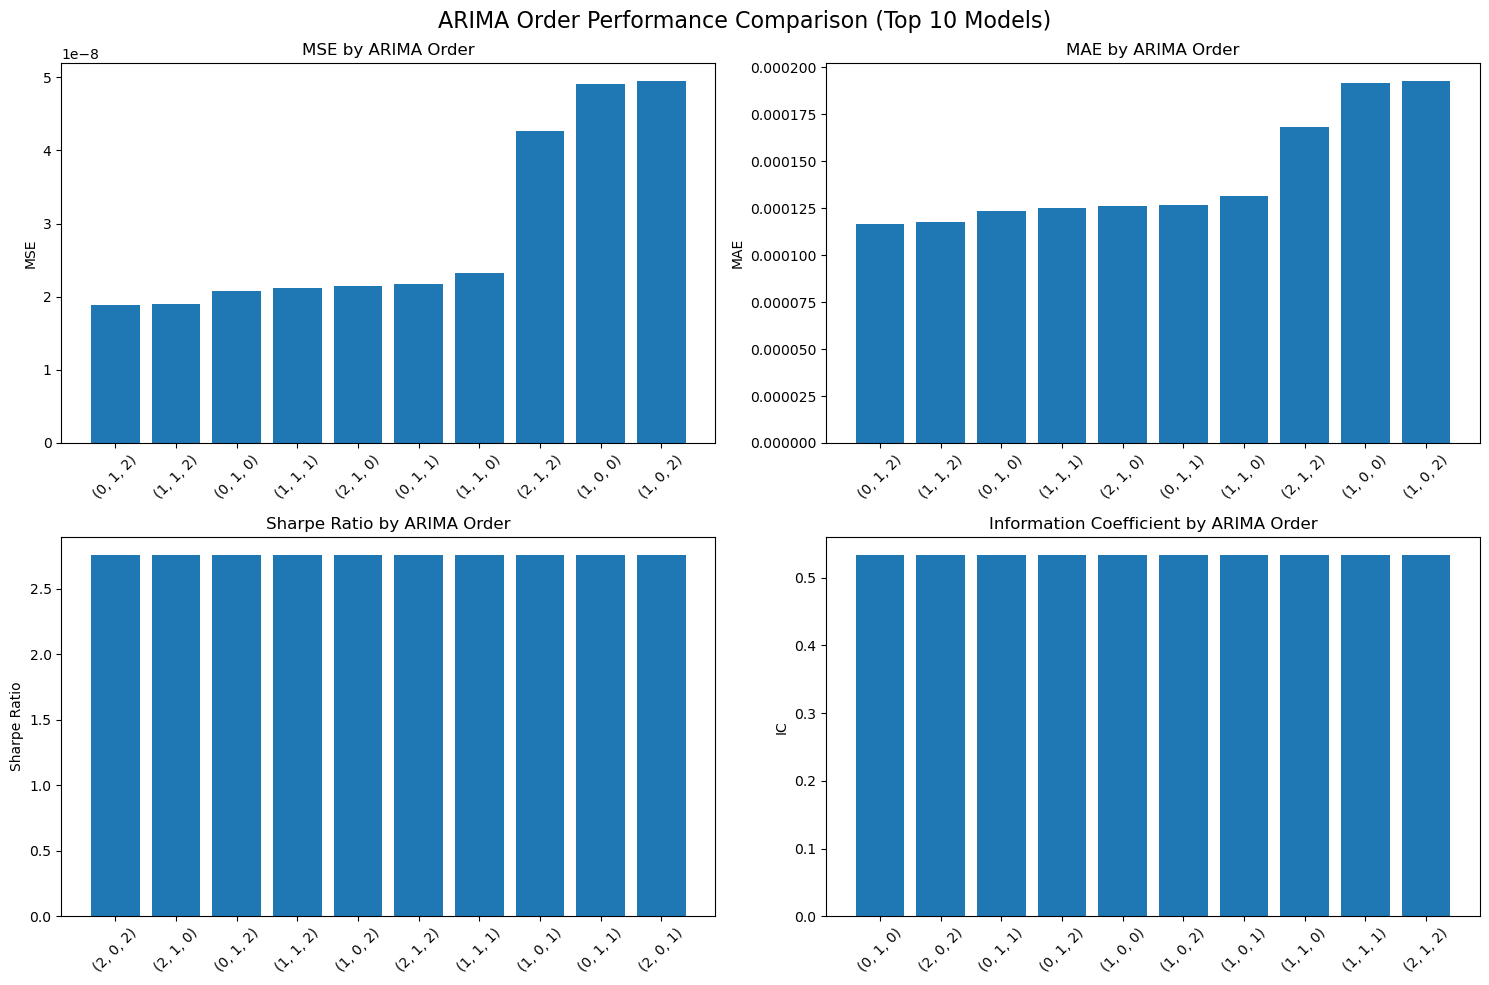


📊 Visualization completed. Showing top 10 models for each metric.


In [10]:
# Optional: Create visualization of results
if results and len(results) > 1:
    import matplotlib.pyplot as plt
    
    # Take only top 10 models for cleaner visualization
    top_10 = min(10, len(results))
    results_df_top10 = results_df.sort_values('MSE').head(top_10)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'ARIMA Order Performance Comparison (Top {top_10} Models)', fontsize=16)
    
    # Plot MSE (sorted by MSE)
    axes[0,0].bar(range(len(results_df_top10)), results_df_top10['MSE'])
    axes[0,0].set_title('MSE by ARIMA Order')
    axes[0,0].set_ylabel('MSE')
    axes[0,0].set_xticks(range(len(results_df_top10)))
    axes[0,0].set_xticklabels([str(order) for order in results_df_top10['order']], rotation=45)
    axes[0,0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # Plot MAE (using same top 10 by MSE for consistency)
    axes[0,1].bar(range(len(results_df_top10)), results_df_top10['MAE'])
    axes[0,1].set_title('MAE by ARIMA Order')
    axes[0,1].set_ylabel('MAE')
    axes[0,1].set_xticks(range(len(results_df_top10)))
    axes[0,1].set_xticklabels([str(order) for order in results_df_top10['order']], rotation=45)
    
    # Plot Sharpe Ratio (top 10 by Sharpe)
    sharpe_top10 = results_df.sort_values('SharpeRatio', ascending=False).head(top_10)
    axes[1,0].bar(range(len(sharpe_top10)), sharpe_top10['SharpeRatio'])
    axes[1,0].set_title('Sharpe Ratio by ARIMA Order')
    axes[1,0].set_ylabel('Sharpe Ratio')
    axes[1,0].set_xticks(range(len(sharpe_top10)))
    axes[1,0].set_xticklabels([str(order) for order in sharpe_top10['order']], rotation=45)
    
    # Plot IC (top 10 by IC)
    ic_top10 = results_df.sort_values('IC', ascending=False).head(top_10)
    axes[1,1].bar(range(len(ic_top10)), ic_top10['IC'])
    axes[1,1].set_title('Information Coefficient by ARIMA Order')
    axes[1,1].set_ylabel('IC')
    axes[1,1].set_xticks(range(len(ic_top10)))
    axes[1,1].set_xticklabels([str(order) for order in ic_top10['order']], rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Visualization completed. Showing top {top_10} models for each metric.")

In [11]:
# ==========================
# Save best weights & full submission
# ==========================
from pathlib import Path
import pickle

# 1) 以最佳 order 重新建模 + 訓練
BEST_MAXITER = 100  # 你可調整
ari_best = ARIMABaseline(order=tuple(map(int, best_order)), maxiter=BEST_MAXITER)
ari_best.fit(train)

# 2) 用「全量」x_test 產生正式 submission（不要用先前的 subset）
submission_full = ari_best.predict_x_test(x_test.copy())

# 3) 基本完整性檢查：每個 window 必須剛好 10 列 time_step=0..9
if not submission_full.empty:
    counts = submission_full.groupby('window_id')['time_step'].nunique()
    assert (counts == 10).all(), "Each window_id must have exactly 10 prediction steps (0..9)."

# 4) 儲存權重（config）到 sample_submission/model_weights.pkl
SUBM.mkdir(parents=True, exist_ok=True)
weights_path = SUBM / "model_weights.pkl"
with open(weights_path, "wb") as f:
    pickle.dump(
        {
            "config": {
                "order": tuple(map(int, best_order)),
                "seasonal_order": (0, 0, 0, 0),
                "enforce_stationarity": False,
                "enforce_invertibility": False,
                "trend": None,
                "maxiter": int(BEST_MAXITER),
                "tol": 1e-6,
                "disp": False,
                "fallback": "naive_last",
                "seed": 1337,
            }
        },
        f,
    )
print(f"✅ Saved best config to: {weights_path}")

# 5) 輸出正式提交檔（評分系統預期檔名通常是 submission.pkl）
submission_path = SUBM / "submission.pkl"          # ← 正式上傳用
# submission_path = SUBM / "submission_example.pkl" # ← 若你想保留成 example
submission_full.to_pickle(submission_path)
print(f"✅ Saved FULL submission to: {submission_path} | rows={len(submission_full)} | windows={submission_full['window_id'].nunique()}")

# 6) 顯示前幾列確認
display(submission_full.head(12))


ARIMA infer: 100%|██████████| 50000/50000 [29:55<00:00, 27.84it/s] 


✅ Saved best config to: /tmp2/b10902109/ICAIF Competition/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit/sample_submission/model_weights.pkl
✅ Saved FULL submission to: /tmp2/b10902109/ICAIF Competition/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit/sample_submission/submission.pkl | rows=500000 | windows=50000


,window_id,time_step,pred_close
0,1,0,0.113074
1,1,1,0.113070
2,1,2,0.113070
3,1,3,0.113070
4,1,4,0.113070
5,1,5,0.113070
6,1,6,0.113070
7,1,7,0.113070
8,1,8,0.113070
9,1,9,0.113070


In [12]:
# Local test on window_id {1,2} with y_test_local.pkl

submission_df = submission_full.copy()

if not y_local_path.exists():
    warnings.warn(f"y_test_local_time.pkl not found at: {y_local_path}. Skip local eval.")
else:
    # NOTE: updated evaluate_all_metrics expects (y_true, y_pred, x_like, y_true_with_base, horizon_step)
    from metrics import evaluate_all_metrics

    target_wids = [1, 2]
    y_local = pd.read_pickle(y_local_path)     # ground truth: ['window_id','time_step','close','event_datetime','token']
    pred_local = submission_df[submission_df["window_id"].isin(target_wids)].copy()

    # Integrity check: each selected window must have exactly 10 prediction steps
    if not pred_local.empty:
        _c = pred_local.groupby("window_id")["time_step"].nunique()
        assert (_c == 10).all(), f"Incomplete prediction steps: {_c.to_dict()}"

    # Build x_like from x_test: use time_step == 59 as base_close reference
    x_test_local = x_test[x_test["window_id"].isin(target_wids)].copy()

    # Normalize dtypes for consistency
    for df in (y_local, pred_local, x_test_local):
        if "window_id" in df: df["window_id"] = df["window_id"].astype("int32")
        if "time_step" in df: df["time_step"] = df["time_step"].astype("int8")
        if "close" in df: df["close"] = df["close"].astype("float32")
        if "pred_close" in df: df["pred_close"] = df["pred_close"].astype("float32")

    # Keep only ground truth for {1,2}
    y_true_local = y_local[y_local["window_id"].isin(target_wids)].copy()

    # Verify that y_true_local has event_datetime column
    if "event_datetime" not in y_true_local.columns:
        raise ValueError("y_test_local_time.pkl must contain 'event_datetime' column")
    
    print(f"\ny_true_local columns: {y_true_local.columns.tolist()}")
    print(f"pred_local columns: {pred_local.columns.tolist()}")
    print(f"x_test_local columns: {x_test_local.columns.tolist()}")

    # Compute metrics: error metrics + strategy-based (CSM/LOTQ/PW) Sharpe, MDD, VaR, ES
    try:
        metrics_dict = evaluate_all_metrics(
            y_true=y_true_local,
            y_pred=pred_local,
            x_test=x_test_local,
            alpha=0.05,
        )
        
        print("\n" + "="*60)
        print("Local Evaluation on window_id 1 & 2 (using NEW metrics)")
        print("="*60)
        
        # Display metrics in a nice format
        metrics_df = pd.DataFrame([metrics_dict]).T.rename(columns={0: "value"})
        display(metrics_df)
    
        
    except Exception as e:
        print(f"\n❌ Error during metric evaluation: {e}")
        import traceback
        traceback.print_exc()

print("\n" + "="*60)
print("Script completed successfully!")
print("="*60)


y_true_local columns: ['window_id', 'time_step', 'close', 'event_datetime', 'token']
pred_local columns: ['window_id', 'time_step', 'pred_close']
x_test_local columns: ['window_id', 'time_step', 'close', 'volume']

Local Evaluation on window_id 1 & 2 (using NEW metrics)


,value
MSE,1.891786e-08
MAE,1.167724e-04
IC,5.333333e-01
IR,2.828427e+00
SharpeRatio,2.759568e+00
MDD,0.000000e+00
VaR,1.187174e-03
ES,1.186768e-03



Script completed successfully!
